# AI 方法找IIR濾波器

測試代入Weights A & B

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import keras
from keras.layers import Layer,InputLayer
import tensorflow as tf
from keras import layers, losses, optimizers,regularizers
from scipy.signal import freqz, welch
import sys
sys.path.append('/content')  # Add the folder containing your module to the Python path

from Signal_proctools import *  # Now you can import your module

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-05-05 04:19:41.448195: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 04:19:41.489054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 04:19:41.489088: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 04:19:41.489112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 04:19:41.497492: I tensorflow/core/platform/cpu_feature_g

In [20]:

# Example usage:
processor = SignalProcessor(96000)
import tensorflow as tf
from tensorflow.keras.layers import Layer

class IIRFilterLayer(Layer):
    def __init__(self, b_initial, a_initial, clip_value=0.1, **kwargs):
        super(IIRFilterLayer, self).__init__(**kwargs)
        self.b_initial = b_initial  # initial b coefficients
        self.a_initial = a_initial  # initial a coefficients
        self.clip_value = clip_value  # Gradient clipping value to enhance stability

    def build(self, input_shape):
        self.b = self.add_weight(name='b',
                                 shape=(len(self.b_initial),),
                                 initializer=tf.constant_initializer(self.b_initial),
                                 trainable=True)
        self.a = self.add_weight(name='a',
                                 shape=(len(self.a_initial),),
                                 initializer=tf.constant_initializer(self.a_initial),
                                 trainable=True,
                                 constraint=lambda x: tf.clip_by_value(x, -self.clip_value, self.clip_value))  # Constrain a coefficients

    def get_config(self):
        config = super(IIRFilterLayer, self).get_config()
        config.update({
            'b_initial': self.b_initial,
            'a_initial': self.a_initial,
            'clip_value': self.clip_value
        })
        return config

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        buf_b = tf.zeros((batch_size, self.b.shape[0]), dtype=inputs.dtype)
        buf_a = tf.zeros((batch_size, self.a.shape[0] - 1), dtype=inputs.dtype)  # a[0] is not used in buffer

        outputs = tf.TensorArray(inputs.dtype, size=time_steps)

        inputs = tf.squeeze(inputs, axis=-1)

        for t in tf.range(time_steps):
            x = inputs[:, t]
            buf_b = tf.concat([x[:, tf.newaxis], buf_b[:, :-1]], axis=1)
            y = tf.reduce_sum(self.b * buf_b, axis=1) - tf.reduce_sum(self.a[1:] * buf_a, axis=1)
            buf_a = tf.concat([y[:, tf.newaxis], buf_a[:, :-1]], axis=1)
            outputs = outputs.write(t, y)

        outputs = outputs.stack()
        outputs = tf.transpose(outputs, [1, 0])
        outputs = tf.expand_dims(outputs, axis=-1)

        return outputs



# Example usage remains the same

# 使用範例
b_coeffs = [ 0.11767986,  0.03872586, -0.12000341, -0.13920431, -0.08211883, -0.06422291,
 -0.1105116,  -0.11431491, -0.08121554 ,-0.07704554 ,-0.0922665 , -0.08900312,
 -0.08321358 ,-0.08409967, -0.07874402, -0.07481685, -0.07388657 ,-0.06991958,
 -0.06736576, -0.07042298 ,-0.07098524 ,-0.0675142 , -0.06544286, -0.06766389]
a_coeffs = [ 0.  , -0.04092572, -0.04031047 ,-0.04046943 ,-0.04089637, -0.04079223,
 -0.04053881, -0.04068774, -0.04089174, -0.04086081, -0.04082956, -0.04090251,
 -0.04095688, -0.04102189, -0.04110515, -0.04116186, -0.04123269, -0.04135416,
 -0.0414171 , -0.04140783 ,-0.04144577, -0.04153574, -0.04156387 ,-0.04141227]       # 某些初始a係數

# 創建層實例
iir_layer = IIRFilterLayer(b_initial=b_coeffs, a_initial=a_coeffs,clip_value=0.01)

# 創建模型
model = keras.Sequential([
    InputLayer(input_shape=(None, 1)),  # 指定輸入的形狀，None代表時間序列長度不固定
    iir_layer
])

# 模型摘要
model.summary()

# 使用模型
length=96000
data = np.random.random(length).reshape(1, length, 1)  # 随机数据作为输入
filtered_data = model.predict(data)
print(filtered_data.shape)  # 查看输出形状

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 iir_filter_layer_7 (IIRFil  (None, None, 1)           48        
 terLayer)                                                       
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 7s 7s/step
(1, 96000, 1)


確認波形與FREQ結果

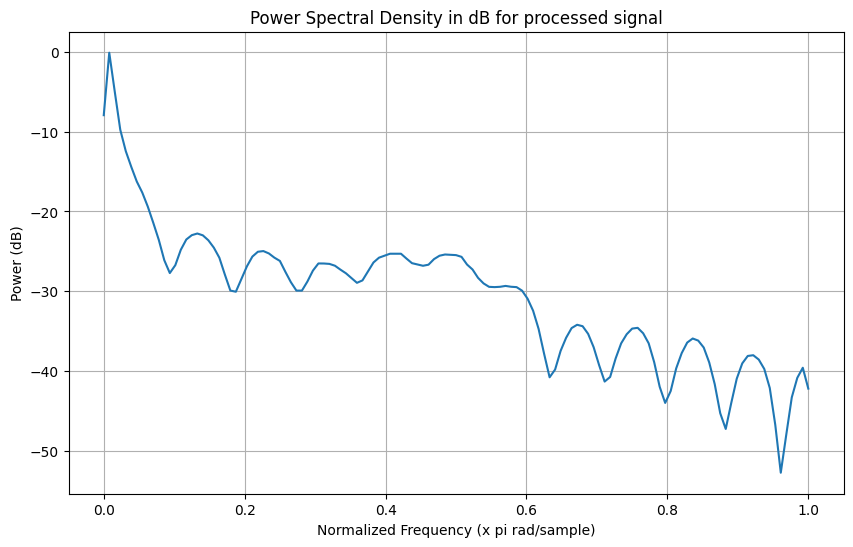

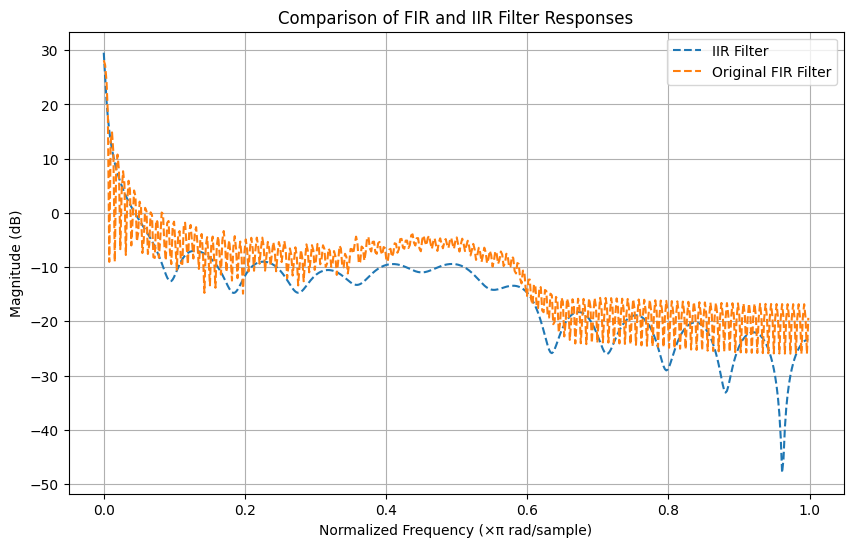

In [21]:

from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt
from scipy.signal import welch
# Compute the power spectral density
filtered_data_ = filtered_data.reshape(-1)
# Compute the power spectral density using Welch's method
frequencies, power = welch(filtered_data_, fs=2*np.pi, nperseg=256)  # `fs=2*np.pi` normalizes frequency to [0, 1]

# Normalize frequencies to [0, 1] range where 1 corresponds to the Nyquist frequency
normalized_frequencies = frequencies / np.pi

# Convert power to decibels (dB)
power_db = 10 * np.log10(power)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(normalized_frequencies, power_db)
plt.title('Power Spectral Density in dB for processed signal')
plt.xlabel('Normalized Frequency (x pi rad/sample)')
plt.ylabel('Power (dB)')
plt.grid(True)
plt.show()

# Frequency response of the optimized IIR filter
a=a_coeffs
a[0]=1
freq, response_ = freqz(b_coeffs, a)

# Plotting the responses
plt.figure(figsize=(10, 6))
plt.plot(freq / np.pi, 20 * np.log10(abs(response_)), label='IIR Filter', linestyle='--')


freq, response_ = freqz(ir, 1)

# Plotting the responses
plt.plot(freq / np.pi, 20 * np.log10(abs(response_)), label='Original FIR Filter', linestyle='--')
plt.title('Comparison of FIR and IIR Filter Responses')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()


超參數設定

In [74]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.99995)

Early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25,start_from_epoch=100)

filepath_="/content/checkpoint/my_IIR_model.h5"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=filepath_,
    monitor="val_loss",  # Assuming you have a validation loss to monitor
    mode='min',          # Save the model when the monitored metric decreases
    save_best_only=True  # Save only the best model
)

optimizer_ = optimizers.legacy.Adam(learning_rate=lr_schedule) #https://keras.io/api/optimizers/

訓練網路

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.optimizers import Adam

# Read the WAV file
fs, data = wavfile.read("test_IR-96k.wav")

# Plot the impulse response
# Find the index of the maximum value in the array
max_index = np.argmax(data)
ir=data[max_index:max_index+256]
ir = (ir - np.min(ir)) / (np.max(ir) - np.min(ir)) * 2 - 1
ir *=0.2

#Signal Generator
length=10000
t, x = processor.generate_noise_signal(length, 0.1)
t, noise = processor.generate_noise_signal(length, 0.01)
d = np.convolve(x + noise, ir)[:length] #"Desired signal"


# Initialize coefficients
N=24
b_initial = np.zeros(N)  # example initial values for b
a_initial = np.zeros(N)  # example initial values for a

# Create the model
model = Sequential([
    InputLayer(input_shape=(None, 1)),
    IIRFilterLayer(b_initial=b_initial, a_initial=a_initial,clip_value=1.0),
    ])

# Compile the model
model.compile(optimizer=optimizer_, loss='mse')

reference_signals = x.reshape(10,1000, 1)  # Reshape to (leng, 1, 1)
d = d[:length].reshape(10, 1000, 1)  # Reshape to (leng, 1, 1)

# Fit the model
# model.fit(x=reference_signals, y=d, epochs=100, batch_size=2)

load_model=0
if load_model==1:
  model = keras.models.load_model(filepath_)

model.fit(x=reference_signals,
          y=d,
          epochs=150,
          batch_size=1,
          callbacks=[model_checkpoint_callback, Early_stopping],
          validation_split=0.1  # Assuming you want to validate using 20% of your data
          )  #訓練 AI

model.save("my_last_trained_CNN.keras") #儲存最後一次的CHECKPOINT FILE

Epoch 1/150
9/9 [==============================] - 5s 482ms/step - loss: 0.0457 - val_loss: 0.0326
Epoch 2/150
9/9 [==============================] - 4s 428ms/step - loss: 0.0447 - val_loss: 0.0318
Epoch 3/150
9/9 [==============================] - 4s 428ms/step - loss: 0.0432 - val_loss: 0.0301
Epoch 4/150
9/9 [==============================] - 4s 416ms/step - loss: 0.0380 - val_loss: 0.0236
Epoch 5/150
9/9 [==============================] - 4s 432ms/step - loss: 0.0215 - val_loss: 0.0164
Epoch 6/150
9/9 [==============================] - 4s 419ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 7/150
9/9 [==============================] - 4s 402ms/step - loss: 0.0097 - val_loss: 0.0140
Epoch 8/150
9/9 [==============================] - 3s 362ms/step - loss: 0.0103 - val_loss: 0.0135
Epoch 9/150
9/9 [==============================] - 4s 426ms/step - loss: 0.0093 - val_loss: 0.0134
Epoch 10/150
9/9 [==============================] - 4s 426ms/step - loss: 0.0088 - val_loss: 0.0135
Epoch 11/

查看訓練後的Weights

In [79]:
# Assuming you have already trained the model
# Get the trained model's weights
trained_weights = model.get_weights()
print(trained_weights)

# Assuming the IIRFilterLayer is the second layer in the model
b_weights = trained_weights[0]  # Index 1 corresponds to the IIRFilterLayer's weights
a_weights = trained_weights[1]

print("b_initial:", b_weights)
print("a_initial:", a_weights)


[array([ 0.17869927,  0.05757239, -0.1592408 , -0.20455487, -0.09360334,
       -0.06611485, -0.1435632 , -0.14836958, -0.08775974, -0.08464765,
       -0.10993961, -0.1005982 , -0.08625165, -0.09112628, -0.08683231,
       -0.07709097, -0.07416419, -0.0691    , -0.06549372, -0.06689264,
       -0.06878274, -0.0643096 , -0.06082928, -0.06460464], dtype=float32), array([ 0.        , -0.03961826, -0.03810244, -0.03837346, -0.03957683,
       -0.03957204, -0.03909983, -0.03948829, -0.0401365 , -0.04020612,
       -0.04021446, -0.04053412, -0.04081556, -0.04106908, -0.04141926,
       -0.04165674, -0.04189205, -0.04236655, -0.04262636, -0.04249647,
       -0.04260553, -0.04313769, -0.04326093, -0.04238993], dtype=float32)]
b_initial: [ 0.17869927  0.05757239 -0.1592408  -0.20455487 -0.09360334 -0.06611485
 -0.1435632  -0.14836958 -0.08775974 -0.08464765 -0.10993961 -0.1005982
 -0.08625165 -0.09112628 -0.08683231 -0.07709097 -0.07416419 -0.0691
 -0.06549372 -0.06689264 -0.06878274 -0.064309

結果確認

1/1 [==============================] - 1s 836ms/step
(1, 10000, 1)
mse: 0.08370280146867316


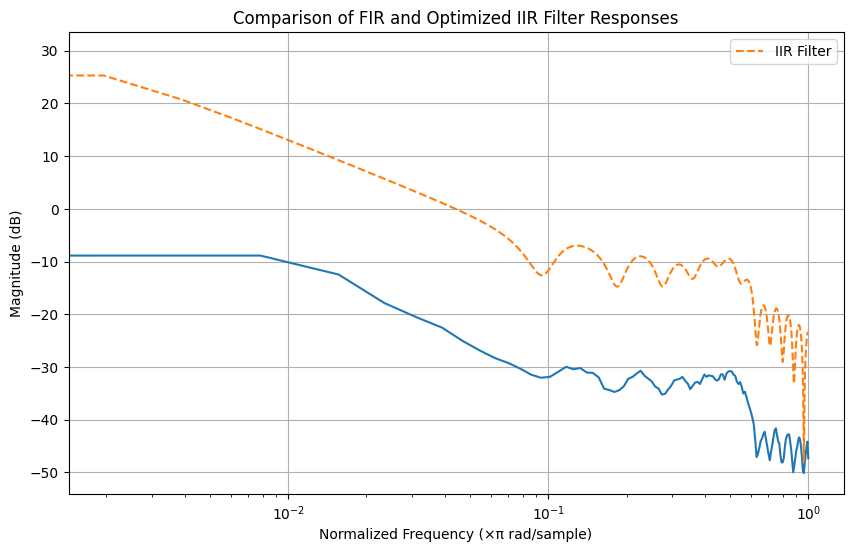

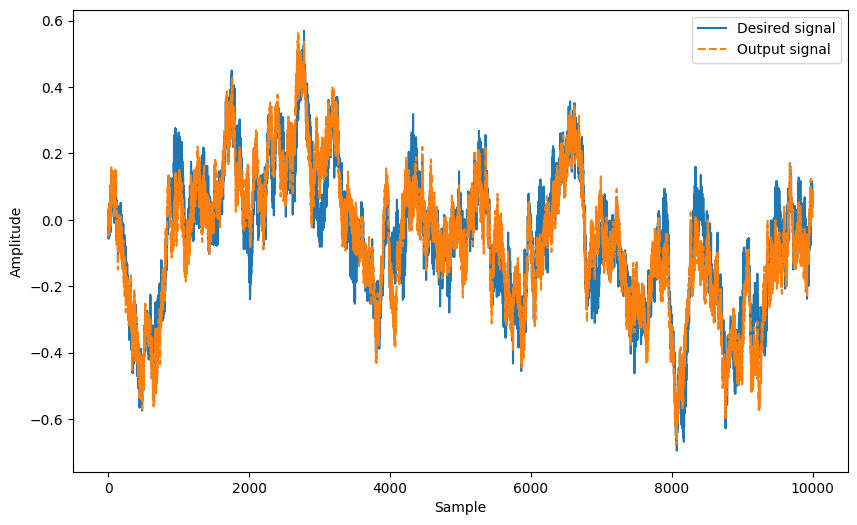

In [80]:
# 使用模型
data = x.reshape(1,length, 1)  # 随机数据作为输入
filtered_data = model.predict(data)
print(filtered_data.shape)  # 查看输出形状

filtered_data_ = filtered_data.reshape(-1)
desired_data=d[:len(filtered_data_)].reshape(-1)

mse=processor.custom_mse(desired_data, filtered_data)
print("mse:",mse)
# Compute the power spectral density using Welch's method
frequencies, power = welch(filtered_data_, fs=2*np.pi, nperseg=256)  # `fs=2*np.pi` normalizes frequency to [0, 1]

# Normalize frequencies to [0, 1] range where 1 corresponds to the Nyquist frequency
normalized_frequencies = frequencies / np.pi

# Convert power to decibels (dB)
power_db = 10 * np.log10(power)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(normalized_frequencies, power_db)
plt.title('Power Spectral Density in dB')
plt.xlabel('Normalized Frequency (x pi rad/sample)')
plt.ylabel('Power (dB)')

# Frequency response of the optimized IIR filter
a=a_coeffs
a[0]=1
freq, response_iir_opt = freqz(b_coeffs, a)

# Plotting the responses
plt.semilogx(freq / np.pi, 20 * np.log10(abs(response_iir_opt)), label='IIR Filter', linestyle='--')
plt.title('Comparison of FIR and Optimized IIR Filter Responses')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()


# Plot the x and y signals

plt.figure(figsize=(10, 6))
plt.plot(desired_data[:10000], label="Desired signal")
plt.plot(filtered_data_[:10000],'--', label="Output signal")

# Add labels and title
plt.xlabel("Sample")
plt.ylabel("Amplitude")


# Add legend
plt.legend()

# Show the plot
plt.show()



放回CPU演算法執行

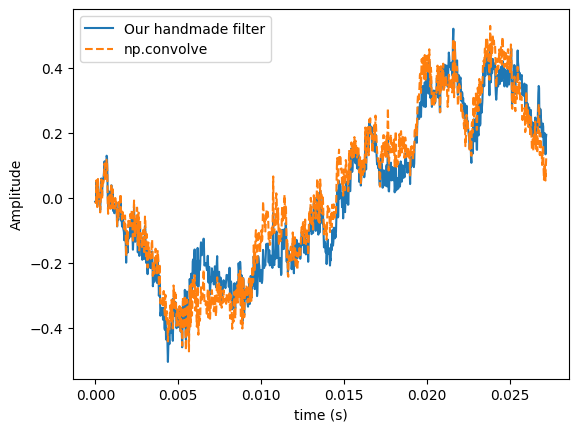

In [81]:
t, x = processor.generate_noise_signal(1200, 0.1)

y=[]
bufb,bufa = np.zeros(len(a_coeffs)),np.zeros(len(a_coeffs)-1)
for n in range(len(x)):
  out, bufb,bufa = processor.iir_convolution(x[n], a_weights, b_weights ,bufa, bufb)
  y.append(out)

y_ = np.convolve(x,ir)[:len(y)]

# Plot the x and y signals
plt.plot(t,y, label="Our handmade filter")
plt.plot(t,y_,'--', label="np.convolve")

# Add labels and title
plt.xlabel("time (s)")
plt.ylabel("Amplitude")

# Add legend
plt.legend()

# Show the plot
plt.show()